In [86]:
# Import Libraries
import pyspark
from pyspark.sql import SparkSession
import mlflow
import sys
import time
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import mlflow.spark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# **Data Wrangling**

### **Batch 1**

In [87]:
# Inisialisasi sesi Spark
spark = SparkSession.builder\
    .appName("SentimentAnalysis")\
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .config("spark.python.worker.reuse", "true") \
    .getOrCreate()

In [88]:
#Load Data

data_path = "C:/Users/lenovo/Downloads/gojek_reviews_1jt.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [89]:
# Exploratory data analysis

df.printSchema()

root
 |-- reviewId: string (nullable = true)
 |-- userName: string (nullable = true)
 |-- userImage: string (nullable = true)
 |-- content: string (nullable = true)
 |-- score: string (nullable = true)
 |-- thumbsUpCount: string (nullable = true)
 |-- reviewCreatedVersion: string (nullable = true)
 |-- at: string (nullable = true)
 |-- replyContent: string (nullable = true)
 |-- repliedAt: string (nullable = true)
 |-- appVersion: string (nullable = true)



In [90]:
df.show(5)

+--------------------+--------------------+--------------------+--------------------+-----+-------------+--------------------+-------------------+--------------------+-------------------+----------+
|            reviewId|            userName|           userImage|             content|score|thumbsUpCount|reviewCreatedVersion|                 at|        replyContent|          repliedAt|appVersion|
+--------------------+--------------------+--------------------+--------------------+-----+-------------+--------------------+-------------------+--------------------+-------------------+----------+
|dacc23f9-42f2-4ed...|         Sukma Sukma|https://play-lh.g...|              mantap|    5|            0|              4.87.2|2024-05-17 12:54:57|                NULL|               NULL|    4.87.2|
|c0aa6207-5587-48d...|Zahara Nur'Ain Fa...|https://play-lh.g...|Sangat membantu u...|    5|            0|              4.86.2|2024-05-17 12:54:36|                NULL|               NULL|    4.86.2|
|b7dd

In [91]:
df.tail(5)

[Row(reviewId='46c417df-7e88-44a1-98f9-03e19e74236e', userName='Mahrizal rizal', userImage='https://play-lh.googleusercontent.com/a-/ALV-UjVlaZj8vt_4_2QUDYwaezuIY08mBVXme6NHfD9zTLVOAkplCAEu', content='Promo nya kurang banyak tambahin napa....', score='5', thumbsUpCount='0', reviewCreatedVersion='4.86.2', at='2024-05-12 09:56:46', replyContent=None, repliedAt=None, appVersion='4.86.2'),
 Row(reviewId='d4e450e5-7c3f-46d9-b087-e76e06932b26', userName='Ameagari no Kaze', userImage='https://play-lh.googleusercontent.com/a-/ALV-UjUyXbuW34OIQkFTZID-DTX8Ok4Ia6ESuHmwmBcOO0daGZ12jPc', content='Jos cuuy walau baru tau isi biaya kirim reguler dkk 😂😂 jujurly kaget', score='5', thumbsUpCount='0', reviewCreatedVersion='4.86.2', at='2024-05-12 09:50:37', replyContent=None, repliedAt=None, appVersion='4.86.2'),
 Row(reviewId='92a355e5-39b8-41c5-8472-fbd48f6e8224', userName='Nining wahyuni', userImage='https://play-lh.googleusercontent.com/a/ACg8ocJRIXCWzau4aiuSpTN9f3Gfmzeih3sBY4mfg3RRJeLhwvKL2w=mo', co

In [92]:
print("Jumlah Baris:", df.count())
print("Jumlah Kolom:", len(df.columns))

Jumlah Baris: 1005512
Jumlah Kolom: 11


In [93]:
df.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|            reviewId|            userName|           userImage|             content|               score|       thumbsUpCount|reviewCreatedVersion|                  at|        replyContent|           repliedAt|          appVersion|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|             1005512|             1004532|             1004532|             1003237|              998075|             1000007|              836162|             1000007|              332352|              324266|              828407|
|   mean|                NULL|      

In [94]:

# Menghilangkan kolom yang diminta
df = df.drop("userImage", "thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt", "appVersion","reviewId")
df.printSchema()

root
 |-- userName: string (nullable = true)
 |-- content: string (nullable = true)
 |-- score: string (nullable = true)



In [95]:
# Menampilkan missing value
df.select([F.count(F.when(F.isnull(c) | F.isnan(c), c)).alias(c) for c in df.columns]).show()

+--------+-------+-----+
|userName|content|score|
+--------+-------+-----+
|     980|   2275| 7437|
+--------+-------+-----+



In [96]:
# Menghilangkan missing value pada kolom tertentu
cols = ["userName", "content", "score"]
df = df.dropna(subset=cols)

# Cek missing value kembali
df.select([F.count(F.when(F.isnull(c) | F.isnan(c), c)).alias(c) for c in df.columns]).show()

+--------+-------+-----+
|userName|content|score|
+--------+-------+-----+
|       0|      0|    0|
+--------+-------+-----+



In [97]:
# Melihat banyaknya duplikasi data
print("Jumlah duplikasi data:", df.count()-df.dropDuplicates().count())

Jumlah duplikasi data: 997071


In [98]:
# Menghilangkan duplikasi data
df = df.dropDuplicates()

# Menampilkan jumlah data bersih
print("Jumlah data bersih setelah menghilangkan duplikasi:", df.count())

Jumlah data bersih setelah menghilangkan duplikasi: 1004


### **Batch 2**

In [99]:
#Upload Dataset Kedua


data_path = "C:/Users/lenovo/Downloads/GOJEK.csv"
df2 = spark.read.csv(data_path, header=True, inferSchema=True)

In [100]:
df2.printSchema()

root
 |-- userName: string (nullable = true)
 |-- score: string (nullable = true)
 |-- at: string (nullable = true)
 |-- content;;;: string (nullable = true)



In [101]:
df2.show(5)

+--------------------+--------------------+--------------------+--------------------+
|            userName|               score|                  at|          content;;;|
+--------------------+--------------------+--------------------+--------------------+
|        Kaze Eyoriツ|                   1| 2024-05-17 09:18:57|         Talekang;;;|
|         Rian Taufik|                   5| 2024-05-17 09:14:11|sangat bermanfaat;;;|
|           Iis Aisah|                   5| 2024-05-17 09:13:03|  Sangat membantu;;;|
|     Sigit Subiyanto|                   5| 2024-05-17 08:43:29|       👍👍👍👍👍;;;|
|"Gustie Pangestu,...| bisa IT ga sih L...| gobllll0g bet an...| kalo mau sedia o...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [102]:
print("Jumlah Baris:", df2.count())
print("Jumlah Kolom:", len(df2.columns))

Jumlah Baris: 228767
Jumlah Kolom: 4


In [103]:
# Menampilkan missing value
df2.select([F.count(F.when(F.isnull(c) | F.isnan(c), c)).alias(c) for c in df2.columns]).show()

+--------+-----+------+----------+
|userName|score|    at|content;;;|
+--------+-----+------+----------+
|       2|20065|176913|    205328|
+--------+-----+------+----------+



In [104]:
# Menghilangkan missing value pada kolom tertentu
cols = ["score","userName","content;;;"]
df2 = df2.dropna(subset=cols)
df2 = df2.drop( "at")

# Cek missing value kembali
df2.select([F.count(F.when(F.isnull(c) | F.isnan(c), c)).alias(c) for c in df2.columns]).show()

+--------+-----+----------+
|userName|score|content;;;|
+--------+-----+----------+
|       0|    0|         0|
+--------+-----+----------+



In [105]:
# Mengubah nama kolom 'content;;;' menjadi 'content'
df2 = df2.withColumnRenamed("content;;;", "content")
# Mengubah susunan kolom menjadi userName, content, score
df2 = df2.select("userName", "content", "score")

# Menampilkan skema DataFrame setelah mengubah nama kolom
df2.show()

+--------------------+--------------------+--------------------+
|            userName|             content|               score|
+--------------------+--------------------+--------------------+
|        Kaze Eyoriツ|         Talekang;;;|                   1|
|         Rian Taufik|sangat bermanfaat;;;|                   5|
|           Iis Aisah|  Sangat membantu;;;|                   5|
|     Sigit Subiyanto|       👍👍👍👍👍;;;|                   5|
|"Gustie Pangestu,...| kalo mau sedia o...| bisa IT ga sih L...|
|          novi yanti|             Bgus;;;|                   5|
|         Ashar Ashar|Tidak mengecewaka...|                   5|
|    Benny Tinambunan|Ok bgt kenapa lam...|                   5|
|   Fedrian Mahyuddin|Selalu tepat wakt...|                   5|
|       Angga Anggara|        4 bintang;;;|                   4|
|"Tober Martinus,1...|bisa minta tolong...| padahal tadi pag...|
|         Johan Punya|               ok;;;|                   5|
|"Rafa adam,1,2024...|mobil&per

In [106]:
# Melihat banyaknya duplikasi data
print("Jumlah duplikasi data:", df2.count()-df2.dropDuplicates().count())

Jumlah duplikasi data: 642


In [107]:
# Menghilangkan duplikasi data
df2 = df2.dropDuplicates()

# Menampilkan jumlah data bersih
print("Jumlah data bersih setelah menghilangkan duplikasi:", df2.count())

Jumlah data bersih setelah menghilangkan duplikasi: 22711


### **Batch 3**

In [108]:
#Upload Dataset Kedua


data_path = "C:/Users/lenovo/Downloads/gojek_reviews_1jt (2).csv"
df3 = spark.read.csv(data_path, header=True, inferSchema=True)

In [109]:
# Exploratory data analysis

df3.printSchema()

root
 |-- reviewId: string (nullable = true)
 |-- userName: string (nullable = true)
 |-- userImage: string (nullable = true)
 |-- content: string (nullable = true)
 |-- score: string (nullable = true)
 |-- thumbsUpCount: string (nullable = true)
 |-- reviewCreatedVersion: string (nullable = true)
 |-- at: string (nullable = true)
 |-- replyContent: string (nullable = true)
 |-- repliedAt: string (nullable = true)
 |-- appVersion;;;: string (nullable = true)



In [110]:
print("Jumlah Baris:", df3.count())
print("Jumlah Kolom:", len(df3.columns))

Jumlah Baris: 1007101
Jumlah Kolom: 11


In [111]:
df3.describe().show()

+-------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|            reviewId|            userName|         userImage|             content|               score|       thumbsUpCount|reviewCreatedVersion|                  at|        replyContent|           repliedAt|       appVersion;;;|
+-------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|             1007101|              978720|            986372|              984773|              982492|              881957|              824152|              772524|              711099|              707525|              715332|
|   mean|                NULL|  1.9280482550

In [112]:
# Menghilangkan kolom yang diminta
df3 = df3.drop("userImage","reviewId", "thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt", "appVersion;;;")
df3.printSchema()

root
 |-- userName: string (nullable = true)
 |-- content: string (nullable = true)
 |-- score: string (nullable = true)



In [113]:
# Menampilkan missing value
df3.select([F.count(F.when(F.isnull(c) | F.isnan(c), c)).alias(c) for c in df3.columns]).show()

+--------+-------+-----+
|userName|content|score|
+--------+-------+-----+
|   28381|  22328|24609|
+--------+-------+-----+



In [114]:
# Menghilangkan missing value pada kolom tertentu
cols = ["score", "userName", "content"]
df3 = df3.dropna(subset=cols)

# Cek missing value kembali
df3.select([F.count(F.when(F.isnull(c) | F.isnan(c), c)).alias(c) for c in df3.columns]).show()

+--------+-------+-----+
|userName|content|score|
+--------+-------+-----+
|       0|      0|    0|
+--------+-------+-----+



In [115]:
# Melihat banyaknya duplikasi data
print("Jumlah duplikasi data:", df3.count()-df3.dropDuplicates().count())

Jumlah duplikasi data: 963238


In [116]:
# Menghilangkan duplikasi data
df3 = df3.dropDuplicates()

# Menampilkan jumlah data bersih
print("Jumlah data bersih setelah menghilangkan duplikasi:", df3.count())

Jumlah data bersih setelah menghilangkan duplikasi: 956


### **Batch 4**

In [117]:
df4 = spark.read.csv("C:/Users/lenovo/Downloads/Review Gojek.csv", header=True, inferSchema=True)

In [118]:
# Exploratory data analysis

df4.printSchema()

root
 |-- userName: string (nullable = true)
 |-- score: string (nullable = true)
 |-- at: string (nullable = true)
 |-- content: string (nullable = true)



In [119]:
print("Jumlah Baris:", df4.count())
print("Jumlah Kolom:", len(df4.columns))

Jumlah Baris: 1041818
Jumlah Kolom: 4


In [120]:
df4.tail(5)

[Row(userName='Chenel Dakwah', score='5', at='5/16/2024 5:14', content='Ramah dan tepat waktu'),
 Row(userName='Arafah HerCom', score='5', at='5/16/2024 5:09', content='mantaf'),
 Row(userName='Iwan Kurniawan', score='5', at='5/16/2024 5:06', content="Yang dekat aja, cs'nya cancelin mulu, saking gg sabarnya nunggu driver"),
 Row(userName='Siti Marifah', score='5', at='5/16/2024 4:50', content='keren'),
 Row(userName='Alvino Ifandi', score='5', at='5/16/2024 4:49', content='aplikasi yang bagus ini')]

In [121]:
df4.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+
|summary|            userName|               score|                  at|             content|
+-------+--------------------+--------------------+--------------------+--------------------+
|  count|             1041815|             1038023|             1036831|             1036514|
|   mean|                 NaN|  3.8403839530102335|                 2.0|8.293103450151043...|
| stddev|                 NaN|  1.6597488974061736|                NULL|6.315839420527599...|
|    min|!!! LU TAU GAK IT...|                    |                    |                    |
|    max|               🤣🤣"|yg satu ramah dan...|uda malam2 pergi ...|                🫶🫶|
+-------+--------------------+--------------------+--------------------+--------------------+



In [122]:
df4 = df4.na.drop(subset=["userName", "score", "at", "content"])

In [123]:
df4.describe().show()

+-------+--------------------+--------------------+----------------+--------------------+
|summary|            userName|               score|              at|             content|
+-------+--------------------+--------------------+----------------+--------------------+
|  count|             1036509|             1036509|         1036509|             1036509|
|   mean|                 NaN|  3.8403610418304877|            NULL|8.293103450151043...|
| stddev|                 NaN|  1.6597635777872728|            NULL|6.315839420527599...|
|    min|"Sutiono "" Yono """|    National ID card|         Inggris|                    |
|    max|            황레나우|trs driver sms ma...|ga cukup uanglah|                🫶🫶|
+-------+--------------------+--------------------+----------------+--------------------+



In [124]:
# Menghilangkan kolom yang diminta
df4 = df4.drop("at")
df4.printSchema()

root
 |-- userName: string (nullable = true)
 |-- score: string (nullable = true)
 |-- content: string (nullable = true)



In [125]:
# Mengubah urutan kolom menjadi "username", "content", "score"
df4 = df4.select("userName", "content", "score")

In [126]:
# Menampilkan missing value
df4.select([F.count(F.when(F.isnull(c) | F.isnan(c), c)).alias(c) for c in df4.columns]).show()

+--------+-------+-----+
|userName|content|score|
+--------+-------+-----+
|       3|      0|    0|
+--------+-------+-----+



In [127]:
# Melihat banyaknya duplikasi data
print("Jumlah duplikasi data:", df4.count()-df4.dropDuplicates().count())

Jumlah duplikasi data: 396766


In [128]:
# Menghilangkan duplikasi data
df4 = df4.dropDuplicates()

# Menampilkan jumlah data bersih
print("Jumlah data bersih setelah menghilangkan duplikasi:", df4.count())

Jumlah data bersih setelah menghilangkan duplikasi: 639743


### **Batch Gabungan**

In [129]:
# Menggabungkan data dari 3 batch yang sudah dibersihkan dari duplikasi
combined_df = df.union(df2).union(df3).union(df4)

# Menampilkan jumlah data setelah penggabungan
print("Jumlah data setelah penggabungan:", combined_df.count())

Jumlah data setelah penggabungan: 664414


In [130]:
combined_df.show()

+--------------------+--------------------+-----+
|            userName|             content|score|
+--------------------+--------------------+-----+
|desyhendrawan Hen...|Keren sangat memb...|    5|
|     Aditya Hermawan|Tolong gojek perb...|    1|
|         Dega Wijaya|Grap tolol babi n...|    1|
|    muhammad safri17|              Mantap|    5|
|           Eri Padli|Pelayanan sangat ...|    5|
|        Achmd Syrfdn|         SYOEKAK BGT|    5|
|        Putra Wiguna|SUSAH DAPAT DRIVE...|    1|
|Zahara Nur'Ain Fa...|Sangat membantu u...|    5|
|     Yadiafnan Mutia|Driver nya molorr...|    1|
|           must rur1|                  ok|    4|
|       Kusuma Widana|                  😜|    4|
|    Rifa Khoirunnisa|saya kalau memesa...|    3|
|        Shafa Assyfa|              mantul|    5|
|Nugroho edi wicak...|Sangat membantu d...|    5|
|       sutisna entis|Sangat membantu a...|    4|
|         Fredoom 104|             lumayan|    3|
| Devi PuspitaNingrum|Keren min apk nya...|    4|
|

In [131]:
# Cek duplikasi data setelah penggabungan
print("Jumlah duplikasi data setelah penggabungan:", combined_df.count() - combined_df.dropDuplicates().count())

Jumlah duplikasi data setelah penggabungan: 1004


In [132]:
# Menghilangkan duplikasi data
combined_df = combined_df.dropDuplicates()

# Menampilkan jumlah data bersih
print("Jumlah data bersih setelah menghilangkan duplikasi:", combined_df.count())
print("Jumlah duplikasi data setelah penggabungan:", combined_df.count() - combined_df.dropDuplicates().count())


Jumlah data bersih setelah menghilangkan duplikasi: 663410
Jumlah duplikasi data setelah penggabungan: 0


In [133]:
from pyspark.sql.functions import col, count, when

# Menghitung jumlah missing value (NaN) pada setiap kolom
combined_df.select([count(when(col(c).isNull(), c)).alias(c) for c in combined_df.columns]).show()



+--------+-------+-----+
|userName|content|score|
+--------+-------+-----+
|       0|      0|    0|
+--------+-------+-----+



In [134]:
combined_df.printSchema()

root
 |-- userName: string (nullable = true)
 |-- content: string (nullable = true)
 |-- score: string (nullable = true)



In [135]:
combined_df.show()

+--------------------+--------------------+-----+
|            userName|             content|score|
+--------------------+--------------------+-----+
|desyhendrawan Hen...|Keren sangat memb...|    5|
|     Aditya Hermawan|Tolong gojek perb...|    1|
|         Dega Wijaya|Grap tolol babi n...|    1|
|    muhammad safri17|              Mantap|    5|
|           Eri Padli|Pelayanan sangat ...|    5|
|        Achmd Syrfdn|         SYOEKAK BGT|    5|
|        Putra Wiguna|SUSAH DAPAT DRIVE...|    1|
|Zahara Nur'Ain Fa...|Sangat membantu u...|    5|
|     Yadiafnan Mutia|Driver nya molorr...|    1|
|           must rur1|                  ok|    4|
|       Kusuma Widana|                  😜|    4|
|    Rifa Khoirunnisa|saya kalau memesa...|    3|
|        Shafa Assyfa|              mantul|    5|
|Nugroho edi wicak...|Sangat membantu d...|    5|
|       sutisna entis|Sangat membantu a...|    4|
|         Fredoom 104|             lumayan|    3|
| Devi PuspitaNingrum|Keren min apk nya...|    4|
|

In [136]:
combined_df.tail(5)

[Row(userName='Virginia Azzahra', content='Sangat membatu dalam perjalanan', score='4'),
 Row(userName='Hamdy Maulidan', content='respon helpchat', score='1'),
 Row(userName='Ridwan Setiawan', content='Punya 3 akun,1 akun udh gojek plus 6 bulan ,2 aku lagi gojek.plus 3 bulan mana kaga ada promo gofood adanya promo bank aneh.', score='4'),
 Row(userName='Rama Dani', content='Saya kecewa karena saldo GO-PAY saya terpotong tanpa ada transaksi yang sukses, dan saldo yg kembali baru setengahnya, saya masih menunggu saldo yang setengahnya lagi', score='3'),
 Row(userName='Mira Wati', content='Ok', score='5')]

In [137]:
print("Jumlah Baris:", combined_df.count())
print("Jumlah Kolom:", len(combined_df.columns))

Jumlah Baris: 663410
Jumlah Kolom: 3


In [138]:
from pyspark.sql.functions import length
combined_df = combined_df.withColumn('length_text', length(combined_df.content))

In [139]:
combined_df.show()

+--------------------+--------------------+-----+-----------+
|            userName|             content|score|length_text|
+--------------------+--------------------+-----+-----------+
|desyhendrawan Hen...|Keren sangat memb...|    5|         21|
|     Aditya Hermawan|Tolong gojek perb...|    1|        171|
|         Dega Wijaya|Grap tolol babi n...|    1|         41|
|    muhammad safri17|              Mantap|    5|          6|
|           Eri Padli|Pelayanan sangat ...|    5|         22|
|        Achmd Syrfdn|         SYOEKAK BGT|    5|         11|
|        Putra Wiguna|SUSAH DAPAT DRIVE...|    1|         55|
|Zahara Nur'Ain Fa...|Sangat membantu u...|    5|         61|
|     Yadiafnan Mutia|Driver nya molorr...|    1|        212|
|           must rur1|                  ok|    4|          2|
|       Kusuma Widana|                  😜|    4|          1|
|    Rifa Khoirunnisa|saya kalau memesa...|    3|        172|
|        Shafa Assyfa|              mantul|    5|          6|
|Nugroho 

# **Text Processing**

### **labelling**

In [140]:
from pyspark.sql.functions import when

# Menambahkan label berdasarkan rating
combined_df = combined_df.withColumn("label", when(combined_df["score"] < 3, "negatif").when(combined_df["score"] > 3, "positif").otherwise("netral"))

# Menampilkan ulasan beserta label
combined_df.select("userName","content","score", "label").show(truncate=False)

+------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+-------+
|userName                      |content                                                                                                                                                                                                             |score|label  |
+------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+-------+
|desyhendrawan Hendrawan       |Keren sangat membantu                                                                                                                                                                       

In [141]:
# Menampilkan jumlah sentimen positif, netral, dan negatif
combined_df.groupBy("label").count().show()

+-------+------+
|  label| count|
+-------+------+
|negatif|185893|
|positif|418966|
| netral| 58551|
+-------+------+



### **Case Folding**

In [142]:
#Mengubah huruf menjadi lower sebelum melakukan tahapan selanjutnya
from pyspark.sql.functions import lower
combined_df = combined_df.withColumn("content",lower(combined_df['content']))

In [143]:
combined_df.show()

+--------------------+--------------------+-----+-----------+-------+
|            userName|             content|score|length_text|  label|
+--------------------+--------------------+-----+-----------+-------+
|desyhendrawan Hen...|keren sangat memb...|    5|         21|positif|
|     Aditya Hermawan|tolong gojek perb...|    1|        171|negatif|
|         Dega Wijaya|grap tolol babi n...|    1|         41|negatif|
|    muhammad safri17|              mantap|    5|          6|positif|
|           Eri Padli|pelayanan sangat ...|    5|         22|positif|
|        Achmd Syrfdn|         syoekak bgt|    5|         11|positif|
|        Putra Wiguna|susah dapat drive...|    1|         55|negatif|
|Zahara Nur'Ain Fa...|sangat membantu u...|    5|         61|positif|
|     Yadiafnan Mutia|driver nya molorr...|    1|        212|negatif|
|           must rur1|                  ok|    4|          2|positif|
|       Kusuma Widana|                  😜|    4|          1|positif|
|    Rifa Khoirunnisa

### **Tokenizer**

In [144]:
from pyspark.sql.functions import regexp_replace, lower
from pyspark.ml.feature import RegexTokenizer

# Mengganti URL dengan spasi
combined_df = combined_df.withColumn('content', regexp_replace(combined_df['content'], 'https\S+', ' '))
# Mengubah teks menjadi huruf kecil
combined_df = combined_df.withColumn('content', lower(combined_df['content']))
# Menghapus kata yang diawali dengan @
combined_df = combined_df.withColumn('content', regexp_replace(combined_df['content'], '@\S+', ' '))
# Menghapus kata yang diawali dengan #
combined_df = combined_df.withColumn('content', regexp_replace(combined_df['content'], '#\S+', ' '))
# Menghapus kata yang berawalan dengan tanda kutip tunggal
combined_df = combined_df.withColumn('content', regexp_replace(combined_df['content'], "\'\w+", ' '))
# Menghapus karakter non-huruf dan non-spasi
combined_df = combined_df.withColumn('content', regexp_replace(combined_df['content'], "[^\w\s]", ' '))
# Menghapus spasi berlebih (2 spasi atau lebih)
combined_df = combined_df.withColumn('content', regexp_replace(combined_df['content'], "\s{2,}", ' '))


# Menggunakan Tokenizer untuk membagi teks menjadi token
tokenizer = RegexTokenizer().setGaps(False).setPattern("\\p{L}+").setInputCol("content").setOutputCol("content_token")

### **Stop Word removal**

In [145]:
from pyspark.ml.feature import StopWordsRemover

# Daftar stop words yang ingin dihilangkan
stop_words = ["saya", "di", "dan", "nya", "ada", "yg", "ini", "ga", "gak", "yang", "mau"]

# Menghilangkan stop words dari kolom "words"
remover = StopWordsRemover().setStopWords(stop_words).setCaseSensitive(False).setInputCol("content_token").setOutputCol("filtered_word")

### **Count vectorizer**

In [146]:
from pyspark.ml.feature import CountVectorizer

import pyspark.ml.feature

In [147]:
cv = CountVectorizer(minTF=1, minDF=8, vocabSize=2**17).setInputCol("filtered_word").setOutputCol("features")

### **Pipeline dan transformer**

In [148]:
from pyspark.ml import Pipeline
# we now create a pipelined estimator.
CVP = Pipeline(stages=[tokenizer, remover, cv]).fit(combined_df)

In [149]:
#applying the transformation to the dataframe.
CVP.transform(combined_df).show(5)

+--------------------+--------------------+-----+-----------+-------+--------------------+--------------------+--------------------+
|            userName|             content|score|length_text|  label|       content_token|       filtered_word|            features|
+--------------------+--------------------+-----+-----------+-------+--------------------+--------------------+--------------------+
|desyhendrawan Hen...|keren sangat memb...|    5|         21|positif|[keren, sangat, m...|[keren, sangat, m...|(17591,[4,6,194],...|
|     Aditya Hermawan|tolong gojek perb...|    1|        171|negatif|[tolong, gojek, p...|[tolong, gojek, p...|(17591,[0,9,13,14...|
|         Dega Wijaya|grap tolol babi n...|    1|         41|negatif|[grap, tolol, bab...|[grap, tolol, bab...|(17591,[290,627,7...|
|    muhammad safri17|              mantap|    5|          6|positif|            [mantap]|            [mantap]|  (17591,[15],[1.0])|
|           Eri Padli|pelayanan sangat ...|    5|         22|positif|

### **TF-IDF**

In [150]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
idf = IDF(inputCol="features", outputCol="tf_idf")

In [151]:
#creating an IDF pipeline
IDF_pip = Pipeline(stages=[CVP, idf]).fit(combined_df)

In [152]:
#applying the transformation.
TF_IDF=IDF_pip.transform(combined_df)
TF_IDF.select('userName', 'filtered_word', 'features', "tf_idf").show(4)

+--------------------+--------------------+--------------------+--------------------+
|            userName|       filtered_word|            features|              tf_idf|
+--------------------+--------------------+--------------------+--------------------+
|desyhendrawan Hen...|[keren, sangat, m...|(17591,[4,6,194],...|(17591,[4,6,194],...|
|     Aditya Hermawan|[tolong, gojek, p...|(17591,[0,9,13,14...|(17591,[0,9,13,14...|
|         Dega Wijaya|[grap, tolol, bab...|(17591,[290,627,7...|(17591,[290,627,7...|
|    muhammad safri17|            [mantap]|  (17591,[15],[1.0])|(17591,[15],[3.06...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 4 rows



In [153]:
bersih=TF_IDF.select(['label','features'])
bersih.show()

+-------+--------------------+
|  label|            features|
+-------+--------------------+
|positif|(17591,[4,6,194],...|
|negatif|(17591,[0,9,13,14...|
|negatif|(17591,[290,627,7...|
|positif|  (17591,[15],[1.0])|
|positif|(17591,[4,7,113],...|
|positif| (17591,[107],[1.0])|
|negatif|(17591,[2,14,58,6...|
|positif|(17591,[0,4,6,16,...|
|negatif|(17591,[0,2,18,33...|
|positif|  (17591,[20],[1.0])|
|positif|       (17591,[],[])|
| netral|(17591,[35,42,43,...|
|positif| (17591,[460],[1.0])|
|positif|(17591,[4,6,139,1...|
|positif|(17591,[4,6,1053,...|
| netral| (17591,[327],[1.0])|
|positif|(17591,[0,10,21,2...|
|negatif|(17591,[60,166,83...|
| netral|(17591,[9,221,172...|
|positif|(17591,[5,40,43,5...|
+-------+--------------------+
only showing top 20 rows



In [154]:
bersih = bersih.withColumn("label",when(bersih['label']=="positif",1).otherwise(0))
bersih.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(17591,[4,6,194],...|
|    0|(17591,[0,9,13,14...|
|    0|(17591,[290,627,7...|
|    1|  (17591,[15],[1.0])|
|    1|(17591,[4,7,113],...|
|    1| (17591,[107],[1.0])|
|    0|(17591,[2,14,58,6...|
|    1|(17591,[0,4,6,16,...|
|    0|(17591,[0,2,18,33...|
|    1|  (17591,[20],[1.0])|
|    1|       (17591,[],[])|
|    0|(17591,[35,42,43,...|
|    1| (17591,[460],[1.0])|
|    1|(17591,[4,6,139,1...|
|    1|(17591,[4,6,1053,...|
|    0| (17591,[327],[1.0])|
|    1|(17591,[0,10,21,2...|
|    0|(17591,[60,166,83...|
|    0|(17591,[9,221,172...|
|    1|(17591,[5,40,43,5...|
+-----+--------------------+
only showing top 20 rows



## Modelling dengan menggunakan Naive Bayes

In [155]:
from pyspark.ml.classification import NaiveBayes
# Use defaults
nb = NaiveBayes()

### **split data**

In [156]:
(train,test)= bersih.randomSplit([0.6,0.4])

### **fit model pipeline pada data train**

In [157]:
spam_predictor = nb.fit(train)

### **Perform predictions on tests dataframe**

In [158]:
test_results = spam_predictor.transform(test)
test_results.show()

+-----+-------------+--------------------+--------------------+----------+
|label|     features|       rawPrediction|         probability|prediction|
+-----+-------------+--------------------+--------------------+----------+
|    0|(17591,[],[])|[-0.9979414364651...|[0.36863752438776...|       1.0|
|    0|(17591,[],[])|[-0.9979414364651...|[0.36863752438776...|       1.0|
|    0|(17591,[],[])|[-0.9979414364651...|[0.36863752438776...|       1.0|
|    0|(17591,[],[])|[-0.9979414364651...|[0.36863752438776...|       1.0|
|    0|(17591,[],[])|[-0.9979414364651...|[0.36863752438776...|       1.0|
|    0|(17591,[],[])|[-0.9979414364651...|[0.36863752438776...|       1.0|
|    0|(17591,[],[])|[-0.9979414364651...|[0.36863752438776...|       1.0|
|    0|(17591,[],[])|[-0.9979414364651...|[0.36863752438776...|       1.0|
|    0|(17591,[],[])|[-0.9979414364651...|[0.36863752438776...|       1.0|
|    0|(17591,[],[])|[-0.9979414364651...|[0.36863752438776...|       1.0|
|    0|(17591,[],[])|[-0.

In [159]:
test_results.printSchema()

root
 |-- label: integer (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [160]:
# Calculate accuracy of the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(test_results)
print("Accuracy:", accuracy)

# Display confusion matrix
test_results.groupBy("label", "prediction").count().show()

Accuracy: 0.8856761414849204
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0| 16611|
|    0|       0.0| 83931|
|    1|       1.0|150914|
|    0|       1.0| 13703|
+-----+----------+------+



In [161]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Definisi evaluator untuk akurasi
acc_eval = MulticlassClassificationEvaluator(metricName='accuracy')

# Definisikan grid parameter untuk k-fold cross-validation
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
    .build()

# Inisialisasi CrossValidator
crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=acc_eval,
                          numFolds=5)  # Jumlah lipatan k-fold

# Melatih model dengan k-fold cross-validation
cvModel = crossval.fit(train)

# Menggunakan model terbaik untuk melakukan prediksi
cv_results = cvModel.transform(test)
cv_results.show()

# Evaluasi akurasi model setelah k-fold cross-validation
cv_acc = acc_eval.evaluate(cv_results)
print("Accuracy of model using k-fold cross-validation: {}".format(cv_acc))

+-----+-------------+--------------------+--------------------+----------+
|label|     features|       rawPrediction|         probability|prediction|
+-----+-------------+--------------------+--------------------+----------+
|    0|(17591,[],[])|[-0.9979428681083...|[0.36863699663077...|       1.0|
|    0|(17591,[],[])|[-0.9979428681083...|[0.36863699663077...|       1.0|
|    0|(17591,[],[])|[-0.9979428681083...|[0.36863699663077...|       1.0|
|    0|(17591,[],[])|[-0.9979428681083...|[0.36863699663077...|       1.0|
|    0|(17591,[],[])|[-0.9979428681083...|[0.36863699663077...|       1.0|
|    0|(17591,[],[])|[-0.9979428681083...|[0.36863699663077...|       1.0|
|    0|(17591,[],[])|[-0.9979428681083...|[0.36863699663077...|       1.0|
|    0|(17591,[],[])|[-0.9979428681083...|[0.36863699663077...|       1.0|
|    0|(17591,[],[])|[-0.9979428681083...|[0.36863699663077...|       1.0|
|    0|(17591,[],[])|[-0.9979428681083...|[0.36863699663077...|       1.0|
|    0|(17591,[],[])|[-0.

In [162]:
# Display confusion matrix for k-fold cross-validation
cv_results.groupBy("label", "prediction").count().show()

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0| 16695|
|    0|       0.0| 84138|
|    1|       1.0|150830|
|    0|       1.0| 13496|
+-----+----------+------+



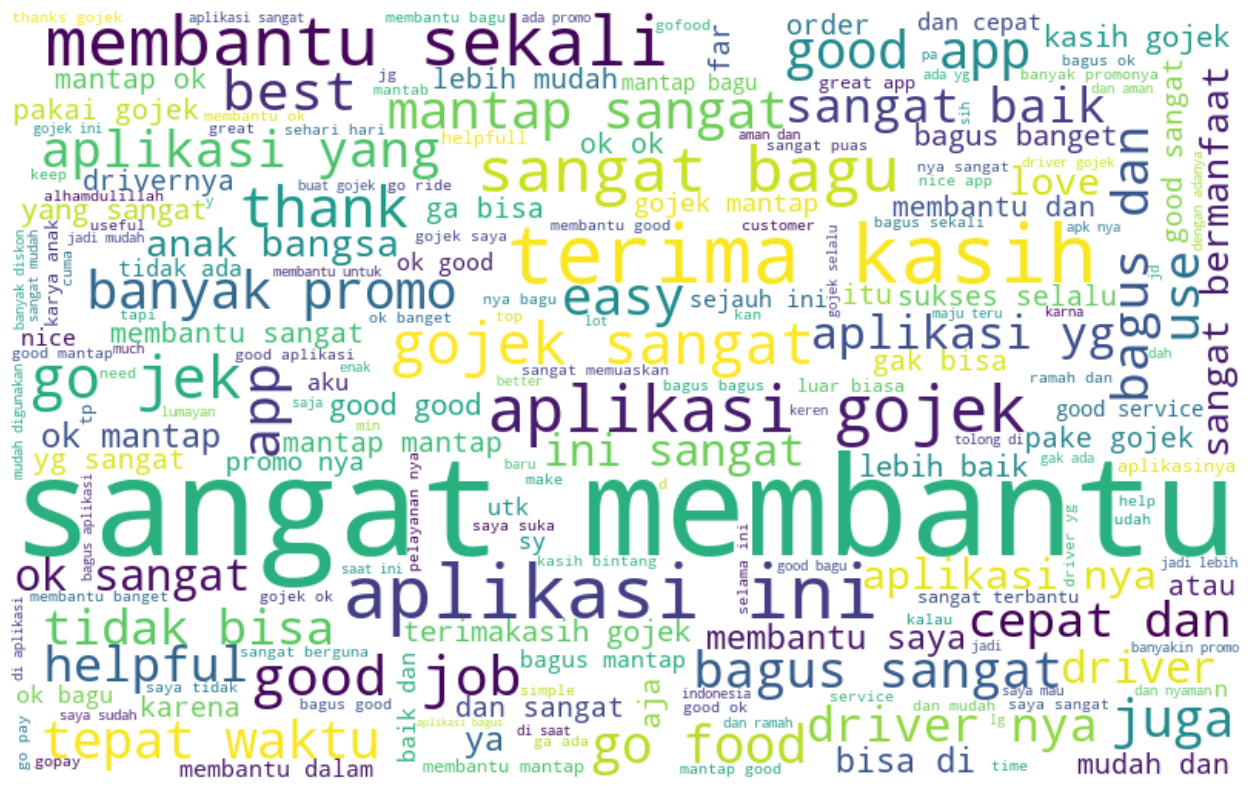

In [163]:
# Visualisasi WordCloud untuk label positif
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_p = TF_IDF.filter(col('score') > 3)

all_words_lem = " ".join([row['content'] for row in df_p.select('content').collect()])

wordcloud = WordCloud(background_color='white', width=800, height=500, random_state=21, max_font_size=130).generate(all_words_lem)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

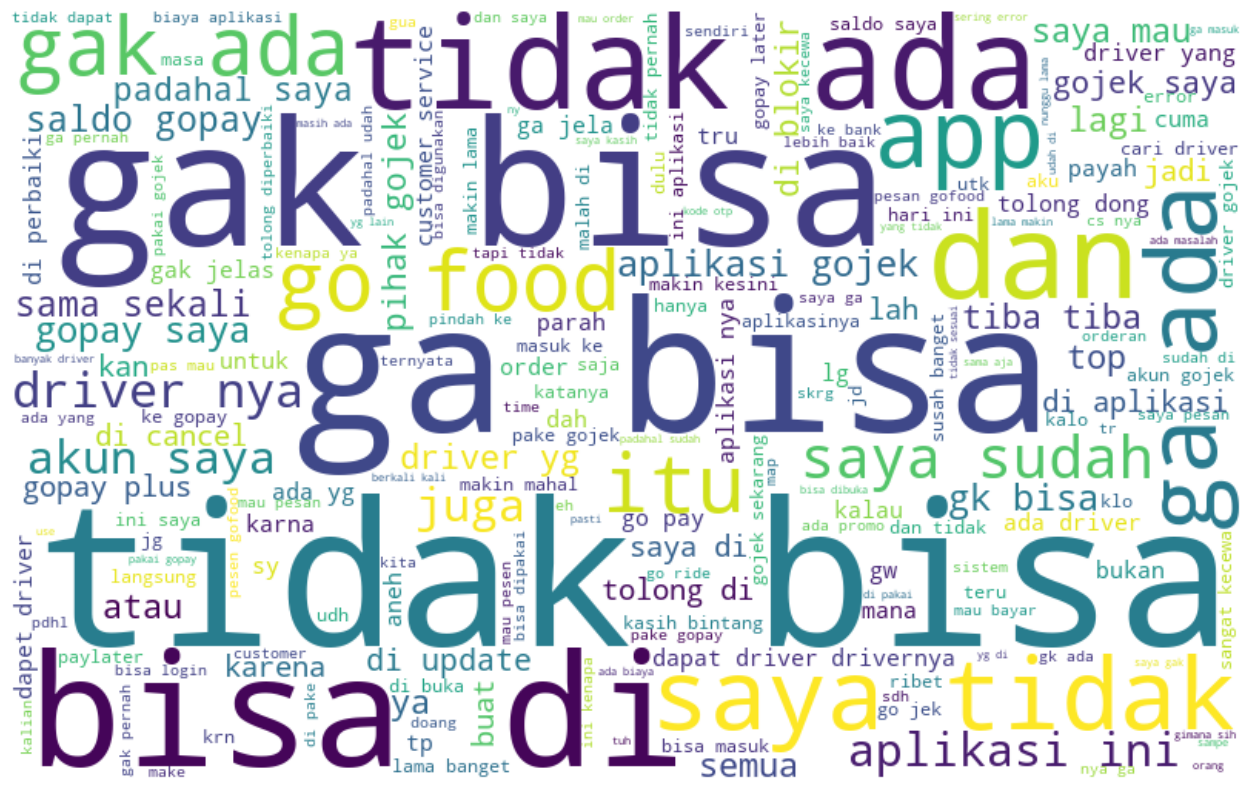

In [164]:
# Visualisasi WordCloud untuk label negatif
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_p = TF_IDF.filter(col('score') < 3)

all_words_lem = " ".join([row['content'] for row in df_p.select('content').collect()])

wordcloud = WordCloud(background_color='white', width=800, height=500, random_state=21, max_font_size=130).generate(all_words_lem)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()